<a href="https://colab.research.google.com/github/yuki0703-sudo/Research/blob/main/MotionPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping #学習時間などのリソース節約のため
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#csvファイルのダウンロード
import pandas as pd
#標準化ライブラリ
from sklearn.preprocessing import MinMaxScaler

#prepare data for LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


#入力フレーム数(1/6秒)
look_back=30

#次元数
dim=10

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Preliminary demo

##make data

[[0.         0.        ]
 [1.99124551 1.52224783]
 [3.24331696 1.25207145]
 ...
 [1.99248368 1.05309292]
 [2.11036279 0.11787911]
 [2.52489173 0.41452894]]


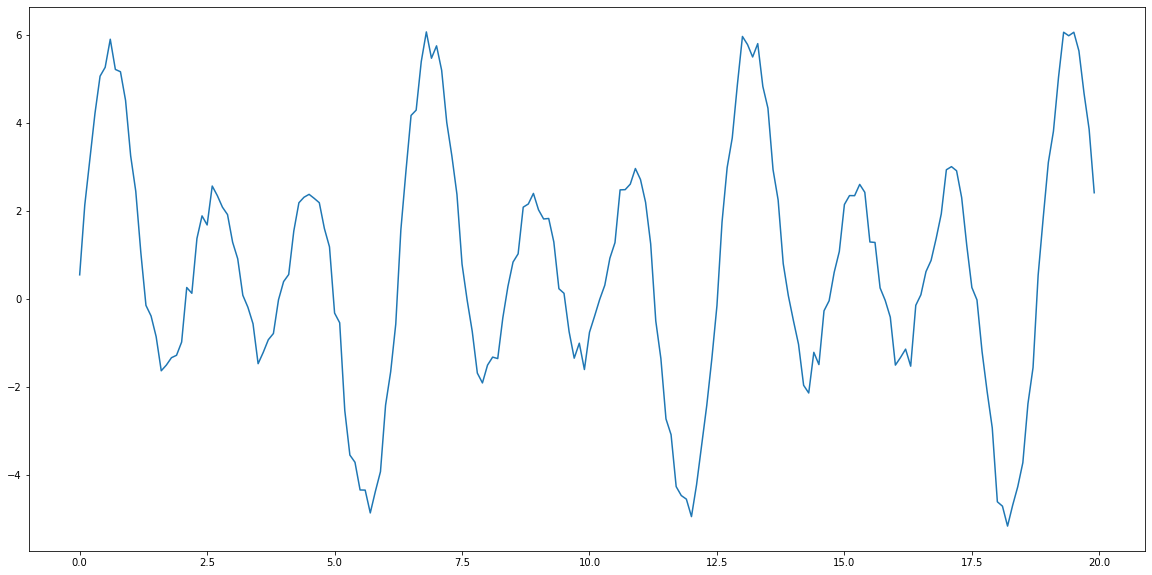

(599, 2)


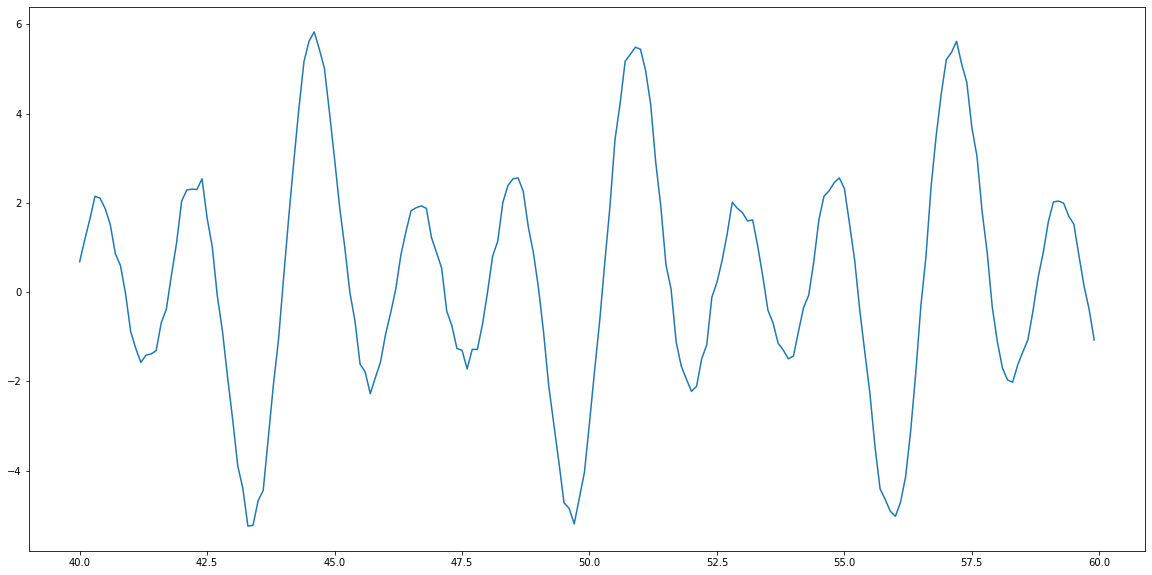

In [ ]:
## prediction of y = sin(x_test) + sin(2*x_test)
x_train = np.arange(0,300,0.1)
y_train = np.asarray(np.sin(x_train)+2*np.sin(2*x_train)+3*np.sin(3*x_train)+np.random.rand(round(10*300))) #when making a nd.array ; np.asarray(x(type ; array))
#print(y)
v_train = list()
for i in range(len(y_train)-1):
  v_train.append(y_train[i+1]-y_train[i])
v_train = np.asarray(v_train)
#print(v_train)
#print(type(v))
x_v_train=np.zeros((len(v_train),2))
for i in range(1,len(v_train)):
  a=list()
  a.append(y_train[i])
  a.append(v_train[i-1])
  x_v_train[i]=a
x_v_train = x_v_train[:len(x_train)-64]
y_train = y_train[126:]
print(x_v_train)
#print(type(x_v))
#print(x_v.shape)
#print(len(x_v))
#print(len(v))
plt.subplots(figsize = (20,10))
plt.plot(x_train[:200],y_train[:200])
plt.show()

x_test = np.arange(40,100,0.1)
y_test = np.asarray(np.sin(x_test)+2*np.sin(2*x_test)+3*np.sin(3*x_test)+0.5*np.random.rand(round(60*10))) #when making a nd.array ; np.asarray(x(type ; array))
#print(y)
v_test = list()
for i in range(len(y_test)-1):
  v_test.append(y_test[i+1]-y_test[i])
v_test = np.asarray(v_test)
#print(type(v))
x_v_test=np.zeros((len(v_test),2))
for i in range(1,len(v_test)):
  a=list()
  a.append(y_test[i])
  a.append(v_test[i-1])
  x_v_test[i]=a

print(x_v_test.shape)
plt.subplots(figsize = (20,10))
plt.plot(x_test[:200],y_test[:200])

##Split data and normalization

In [ ]:
def mktraindataset(data,lookback,lookahead):
  data = data.tolist()
  train = []
  for k in range(len(data)-lookback-lookahead):
    temp = []
    for i in range(lookback):
    #for j in range(dim):
    #temp_2 = []
      temp.append(data[k+i])
    #temp.append(temp_2)
    train.append(temp)
  train = np.asarray(train)
  print(train.shape)
  return train

def mktestdataset(data,lookback,lookahead):
  data = data.tolist()
  test = []
  for k in range(lookback+lookahead,len(data)):
    test.append(data[k])
  test = np.asarray(test)
  print(test.shape)
  return test

In [ ]:
print(x_v_train)
print(x_v_test)

[[-9.39828193e-04 -1.26304512e-01]
 [ 2.58456175e-01  9.80855926e-01]
 [ 4.98213189e-01  9.03956698e-01]
 ...
 [ 2.58174225e-01  3.69518226e-01]
 [ 3.52796650e-01  2.80298041e-01]
 [ 4.13315509e-01  1.33751414e-01]]
[[-0.01709101 -0.12279576]
 [ 0.20436821  0.34311667]
 [ 0.26700668  0.12734155]
 ...
 [-0.70476356 -0.94167033]
 [-0.84393986 -0.6785754 ]
 [-0.92273768 -0.43746302]]


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_v_train = scaler.fit_transform(x_v_train)
x_v_test = scaler.fit_transform(x_v_test)

lookback = 5
lookahead = 50
train_X = mktraindataset(x_v_train,lookback,lookahead)
train_y = mktestdataset(x_v_train,lookback,lookahead)
test_X = mktraindataset(x_v_test,lookback,lookahead)
test_y = mktestdataset(x_v_test,lookback,lookahead)

(2881, 5, 2)
(2881, 2)
(544, 5, 2)
(544, 2)


In [ ]:
print(train_X[:1])

##Define Attention Layer

In [ ]:
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,SimpleRNN, LSTM,Dropout,Convolution2D,MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob
from keras.layers import Layer
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e/x.shape[-1]**(1/2))
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

##Prediction model

In [ ]:
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,SimpleRNN, LSTM,Dropout,Convolution2D,MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob
from keras.layers import Layer
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e/x.shape[-1]**(1/2))
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
        
from keras.layers import LeakyReLU

# design network
def LSTMwithattention(input_shape):
    from keras.engine.sequential import model_serialization
    from tensorflow_datasets.core.dataset_builder import units
    from tensorflow import keras
    from tensorflow.keras import Input, Model
    from tensorflow.keras.layers import TimeDistributed, Activation
    from keras import backend as K
    from keras.layers.core import Reshape
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

    inputs = Input(input_shape=input_shape)
    x = LSTM(126)(inputs)
    x = Dropout(0.1)(x)
    x = attention()(x)
    outputs = Dense(dim,trainable=True,activation = 'tanh')(x)
    model= Model(inputs = inputs, outputs = outputs)

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001,decay = 0.0001))
    return model


In [ ]:
# Create the model with attention, train and evaluate
model = LSTMwithattention(input_shape = (train_X.shape[1],train_X.shape[2]))
model.summary()    

##Dense Model

In [ ]:
from keras.layers import LeakyReLU
dim = 2
model = Sequential()
model.add(LSTM(300, #return_sequences = True, 
               input_shape=(train_X.shape[1], train_X.shape[2]))) #(LSTM(hiddenLayer,inputshape(input_frame,dimension(the number of features))))
model.add(Dropout(0.1))
#model.add(LSTM(20))
#model.add(Dropout(0.1))
#model.add(LSTM(10))
#model.add(Dense(20))
#model.add(LeakyReLU(alpha=0.3))
#model.add(LSTM(100))
#model.add(Dense(100,activation='relu'))
model.add(Dense(dim))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(dim,activation="tanh"))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001,decay = 0.0001))

#train

Epoch 1/120
81/81 - 2s - loss: 0.0935 - val_loss: 0.0604 - 2s/epoch - 24ms/step
Epoch 2/120
81/81 - 0s - loss: 0.0594 - val_loss: 0.0536 - 312ms/epoch - 4ms/step
Epoch 3/120
81/81 - 0s - loss: 0.0555 - val_loss: 0.0515 - 278ms/epoch - 3ms/step
Epoch 4/120
81/81 - 0s - loss: 0.0531 - val_loss: 0.0497 - 319ms/epoch - 4ms/step
Epoch 5/120
81/81 - 0s - loss: 0.0518 - val_loss: 0.0492 - 313ms/epoch - 4ms/step
Epoch 6/120
81/81 - 0s - loss: 0.0499 - val_loss: 0.0469 - 271ms/epoch - 3ms/step
Epoch 7/120
81/81 - 0s - loss: 0.0472 - val_loss: 0.0422 - 275ms/epoch - 3ms/step
Epoch 8/120
81/81 - 0s - loss: 0.0416 - val_loss: 0.0379 - 279ms/epoch - 3ms/step
Epoch 9/120
81/81 - 0s - loss: 0.0391 - val_loss: 0.0365 - 274ms/epoch - 3ms/step
Epoch 10/120
81/81 - 0s - loss: 0.0375 - val_loss: 0.0353 - 271ms/epoch - 3ms/step
Epoch 11/120
81/81 - 0s - loss: 0.0360 - val_loss: 0.0332 - 301ms/epoch - 4ms/step
Epoch 12/120
81/81 - 0s - loss: 0.0347 - val_loss: 0.0326 - 296ms/epoch - 4ms/step
Epoch 13/120
81

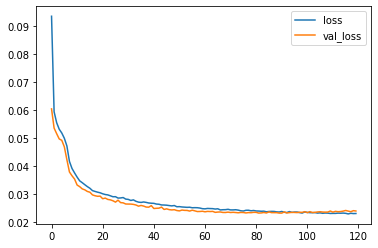

In [ ]:
history = model.fit(train_X, train_y, epochs=120, batch_size=32, validation_split=0.1, verbose=2, shuffle=False)#callbacks=[early_stopping])
# plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

##Evaluation

In [ ]:
#from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
def mean_squared_error(data1,data2):
  s=0
  for i in range(len(data1)):
    s+=(data1[i][0]-data2[i][0])**2+(data1[i][1]-data2[i][1])**2
  s=s/len(data1)
  return s**(1/2)

#trainScore = mean_squared_error(trainPredict,trainY)
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = mean_squared_error(testPredict,testY)
#print('Test Score: %.2f RMSE' % (testScore))

# make a prediction
yhat = model.predict(test_X)
yhat_train=model.predict(train_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X_eva[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
#inv_yhat = inv_yhat[:,:]
inv_yhat_train = scaler.inverse_transform(yhat_train)
#inv_yhat = inv_yhat[:,:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X_eva[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y_train = scaler.inverse_transform(train_y)
inv_y = inv_y[:,:]

# calculate RMSE
print(inv_yhat)
rmse_test = mean_squared_error(inv_y, inv_yhat)
rmse_train = mean_squared_error(inv_y_train, inv_yhat_train)
print('Test RMSE: %.3f' % rmse_test)
print('Train RMSE: %.3f' % rmse_train)

91/91 [==============================] - 1s 2ms/step
[[-1.1399825  -0.40723687]
 [-1.337917   -0.23995514]
 [-1.5844814  -0.11093742]
 ...
 [-3.369223   -0.5681549 ]
 [-4.1356244  -0.5742161 ]
 [-4.5400057  -0.38116848]]
Test RMSE: 1.186
Train RMSE: 0.606


##Plot test data

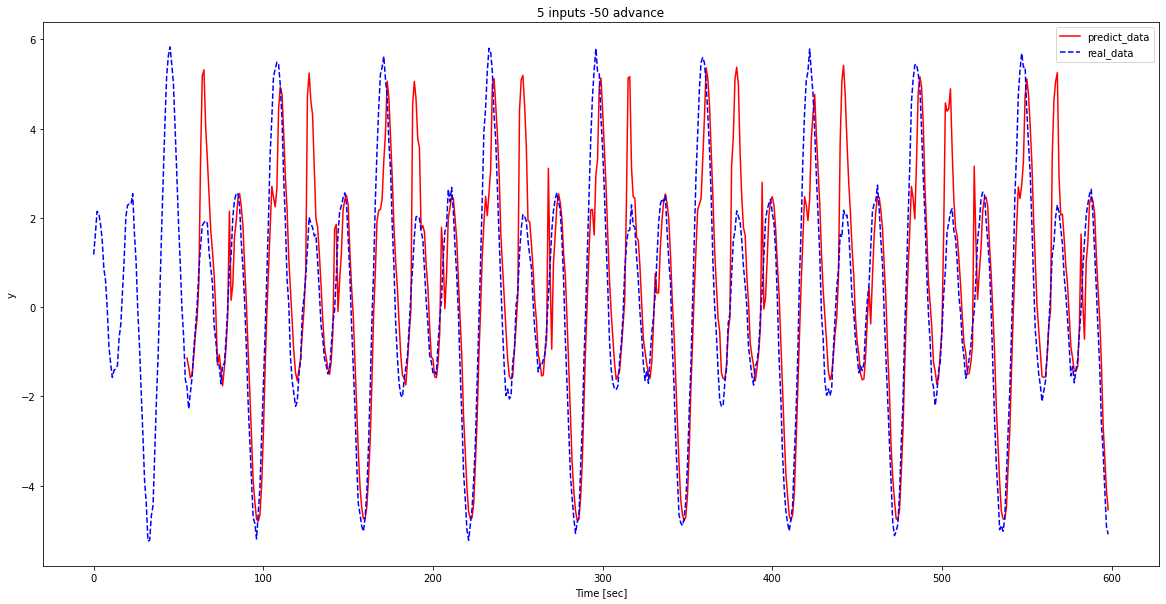

In [ ]:
num_hat=[]
xhat = []
for i in range(len(y_test)-1):
  if i<lookback+lookahead:
    xhat.append(None)
  else:
    xhat.append(inv_yhat[i-lookback-lookahead,0])
for i in range(len(y_test)-1):
  num_hat.append(i)


x=inv_y[:,0]
num=[]
for i in range(len(y_test)-1):
  num.append(i)
#グラフのプロット
plt.subplots(figsize = (20,10))
plt.plot(num_hat ,xhat, color="r", linestyle = '-',label="predict_data")
plt.plot(num, y_test[1:], color="b", linestyle='--',label="real_data")
plt.ylabel("y")
plt.xlabel("Time [sec]")
plt.title("5 inputs -50 advance")
plt.legend()
plt.show()

In [ ]:
#dataset for fututre prediction
values_pred_eva = x_v_test
values_pred = x_v_test[:look_back,:]

#print(values_pred)
# ensure all data is float
values_pred = values_pred.astype('float32')
values_pred_eva = values_pred_eva.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_pred = scaler.fit_transform(values_pred)
scaled_eva = scaler.fit_transform(values_pred_eva)
# frame as supervised learning
reframed_pred = series_to_supervised(scaled_pred, look_back, 1)

# drop columns we don't want to predict
#reframed_train.drop(reframed_train.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#s=np.append(scaled_pred,[336,366])
#print(s.shape)
print(scaled_pred.shape)

(30, 2)


#predict long-term

In [ ]:
#fps=200
look_back = 63
lookahead = 64

predict = model.predict(test_X)
print("predicted data shape:",predict.shape)


#step-by-step predict

In [ ]:
init_dat=scaled_pred
fps=30
# 未来の予測データを保存していく変数

print(init_dat.shape)
future_result = scaled_eva[:look_back,:]


# 未来予想
for step2 in range(50):

    test_data = np.reshape(init_dat, (1,look_back, dim))
    batch_predict = model.predict(test_data)
    init_dat=np.delete(init_dat,0,axis=0)
    init_dat = np.append(init_dat,batch_predict, axis=0)
    #print(batch_predict)
    future_result = np.append(future_result, batch_predict,axis=0)
    print(future_result)

inv_ypred = scaler.inverse_transform(future_result)
inv_yeva =scaler.inverse_transform(scaled_eva)



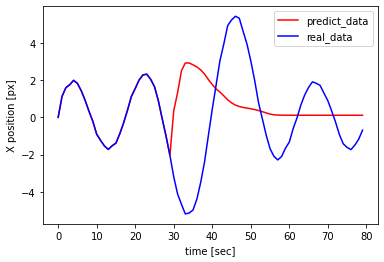

In [ ]:

x_pred=inv_ypred[:,0]
num_pred=[]
for i in range(len(x_pred)):
  num_pred.append(i)


x_eva=inv_yeva[:80,0]
num_eva=[]

for i in range(80):
  num_eva.append(i)


# sin波をプロット
plt.figure()
plt.plot(num_pred,x_pred, color="r", label="predict_data")
plt.plot(num_eva,x_eva, color="b", label="real_data")
plt.xlabel("time [sec]")
plt.ylabel("X position [px]")
#plt.title("X prediction(5 frames/hidden layer:100)")
#plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()

#Motion prediction

#Dataset

## only position

In [ ]:
#training data
file1=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/1.csv")
file2=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv",header=0)

#test data
file3=pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/3.csv",header=0)

#test data preparation
value1_train=file1.values
value2=file2.values
value2_train = value2[:1300,:]
value_predict = value2[1300:,:]
value3=file3.values
value3_train = value3[:800,:]
value_test = value3[800:,:]

print(value_predict.shape)

# ensure all data is float
value1_train = value1_train.astype('float32')
value2_train = value2_train.astype('float32')
value3_train = value3_train.astype('float32')
value_test = value_test.astype('float32')

(400, 10)


## including velocity

In [ ]:
def pos2vel(src):
  import pandas as pd
  file = pd.read_csv(filepath_or_buffer=src)
  data = file.values
  data = data.tolist()
  value = []
  len_data = 10 # len(data[i])
  for i in range(1,len(data)):
    temp = data[i]
    for j in range(len(data[i])):
      #print((i,j))
      #print((i,j))
      vel = data[i][j]-data[i-1][j]
      temp.append(vel)
    value.append(temp)
  value = np.array(value)
  print('data shape : ', value.shape)
  return value

In [ ]:
##only position data to position and velocity data
value1_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/1.csv")
value2_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv")[:1300,:]
value_predict = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/2.csv")[1300:,:]
value3_train = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/3.csv")[:800,:]
value_test = pos2vel("/content/gdrive/My Drive/YAMAKAWA_LAB/MarkerTracking_1007/1007/3.csv")[800:,:]

# ensure all data is float
value1_train = value1_train.astype('float32')
value2_train = value2_train.astype('float32')
value3_train = value3_train.astype('float32')
value_test = value_test.astype('float32')

data shape :  (3572, 20)
data shape :  (1699, 20)
data shape :  (1699, 20)
data shape :  (1406, 20)
data shape :  (1406, 20)


## Noise Cancel

<Figure size 432x288 with 0 Axes>

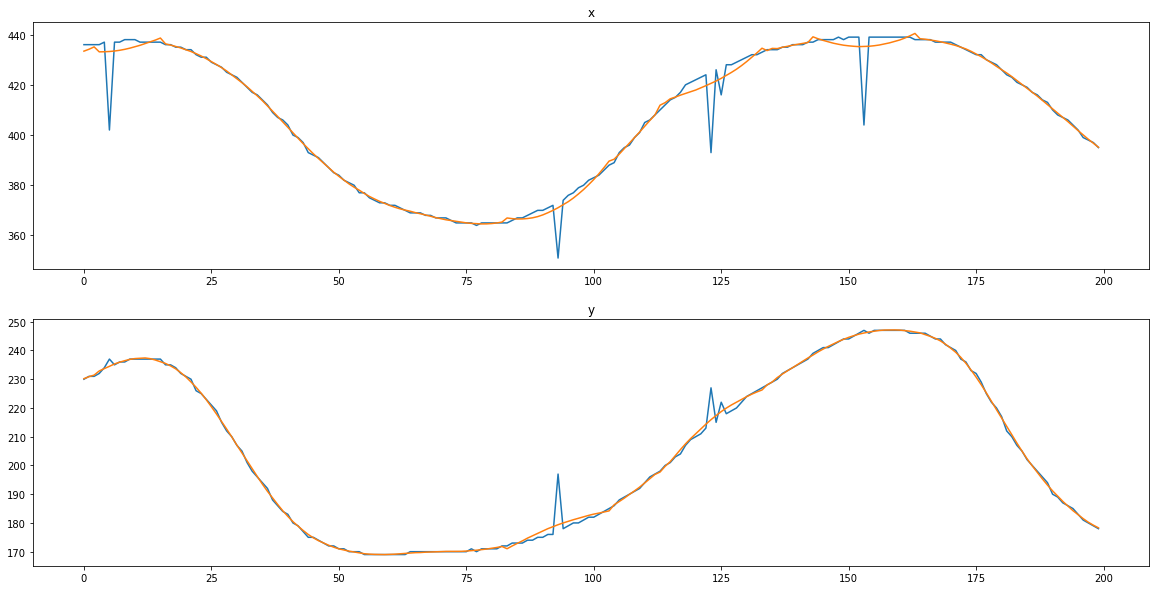

In [ ]:
# noise cancel
import scipy as sp
from scipy import signal
window = 21 # window length must be odd
deg = 3
def noise_removal(data,window,deg):
	smooth = np.zeros((len(data),len(data[1])))
	for i in range(len(value1_train[1])):
		smooth[:,i] = signal.savgol_filter(data[:,i],window,deg) 
	return smooth
smooth1_train = noise_removal(value1_train,window,deg)
smooth2_train = noise_removal(value2_train, 9, deg)
smooth3_train = noise_removal(value3_train, 11, deg)
smooth_test = noise_removal(value_test, 5, deg)
smooth_predict = noise_removal(value_predict, 5, deg)

#インストールしたデータのプロット
#specify columns to plot
groups=[0,1]
title=["x","y"]
i=1
plt.figure()
plt.subplots(figsize = (20,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(value1_train[1000:1200, group])
	plt.plot(smooth1_train[1000:1200, group])
	plt.title(title[group])
	i += 1
plt.show()

##Split data for starting with LSTM layer

In [ ]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled1_train = scaler.fit_transform(smooth1_train)
scaled2_train = scaler.fit_transform(smooth2_train)
scaled3_train = scaler.fit_transform(smooth3_train)
scaled_test = scaler.fit_transform(smooth_test)
scaled_predict = scaler.fit_transform(smooth_predict)

In [ ]:
##########
lookback = 50
lookahead = 50 #250 msec

def transform_NN(before_data,lookback,lookahead):
  before_data = before_data.tolist()
  train1_X = []
  train1_y = []
  for j in range(len(before_data)-lookback-lookahead):
    train1_y.append(before_data[lookback+lookahead+j-1])
    temp = before_data[j:j+lookback]
    temp_list =[]
    for i in range(lookback):
      #for k in range(len(temp[i])):
      temp_list.append(temp[i])
    train1_X.append(temp_list)
  train1_X = np.array(train1_X)
  train1_y = np.array(train1_y)
  print("shape : (X,y):", (train1_X.shape,train1_y.shape))
  return train1_X,train1_y

In [ ]:
train1_X, train1_y = transform_NN(scaled1_train,lookback,lookahead)
train2_X, train2_y = transform_NN(scaled2_train,lookback,lookahead)
train3_X, train3_y = transform_NN(scaled3_train,lookback,lookahead)
test_X, test_y = transform_NN(scaled_test,lookback,lookahead)
predict_X, predict_y = transform_NN(scaled_predict,lookback,lookahead)

shape : (X,y): ((3472, 50, 20), (3472, 20))
shape : (X,y): ((1200, 50, 20), (1200, 20))
shape : (X,y): ((700, 50, 20), (700, 20))
shape : (X,y): ((506, 50, 20), (506, 20))
shape : (X,y): ((299, 50, 20), (299, 20))


## Combine all data

In [ ]:
def combine_train(data1,data2,data3):
  data1 = data1.tolist()
  data2 = data2.tolist()
  data3 = data3.tolist()
  train = []
  for i in range(len(data1)): #(1200,100,20),1200
    temp= []
    for j in range(len(data1[i])):#100
      temp_2 =[]
      for k in range(len(data1[i][j])):#20
        temp_2.append(data1[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  for i in range(len(data2)): #(1200,100,20),1200
    temp= []
    for j in range(len(data2[i])):#100
      temp_2 =[]
      for k in range(len(data2[i][j])):#20
        temp_2.append(data2[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  for i in range(len(data3)): #(1200,100,20),1200
    temp= []
    for j in range(len(data3[i])):#100
      temp_2 =[]
      for k in range(len(data3[i][j])):#20
        temp_2.append(data3[i][j][k])
      temp.append(temp_2)
    train.append(temp)
  train = np.asarray(train)
  print('train data shape', train.shape)
  return train

def combine_label(data1,data2,data3):
  data1 = data1.tolist()
  data2 = data2.tolist()
  data3 = data3.tolist()
  train_label = []
  for i in range(len(data1)): #(1200,100,20),1200
    temp= []
    for j in range(len(data1[i])):#100
      temp.append(data1[i][j])
    train_label.append(temp)
  for i in range(len(data2)): #(1200,100,20),1200
    temp= []
    for j in range(len(data2[i])):#100
      temp.append(data2[i][j])
    train_label.append(temp)
  for i in range(len(data3)): #(1200,100,20),1200
    temp= []
    for j in range(len(data3[i])):#100
      temp.append(data3[i][j])
    train_label.append(temp)
  train_label = np.asarray(train_label)
  print('train_label shape:',train_label.shape)
  return train_label

In [ ]:
train = combine_train(train1_X,train2_X,train3_X)
train_label = combine_label(train1_y,train2_y,train3_y)

train data shape (5372, 50, 20)
train_label shape: (5372, 20)


## NN model : start with LSTM layer

##Define attention layer

In [ ]:
import numpy as np
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense,SimpleRNN, LSTM,Dropout,Convolution2D,MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import glob
from keras.layers import Layer
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e/x.shape[-1]**(1/2))
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
        
from keras.layers import LeakyReLU



#LSTM with Attention layer

In [ ]:
# design network
def create_LSTMwithAttention(input_shape = train.shape[1:]):#input_shape):
    from keras.engine.sequential import model_serialization
    from tensorflow_datasets.core.dataset_builder import units
    from tensorflow import keras
    from tensorflow.keras import Input, Model
    from tensorflow.keras.layers import TimeDistributed, Activation,BatchNormalization
    from keras import backend as K
    from keras.layers.core import Reshape

    #print(input_shape)
    inputs = Input(input_shape=(50,20))
    x = LSTM(300,return_sequences = True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(100)(x)
    x = BatchNormalization()(x)
    x = attention()(x)
    outputs = Dense(dim,trainable=True,activation = 'tanh')(x)
    model= Model(inputs = inputs, outputs = outputs)

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001,decay = 0.0001))
    return model

In [ ]:
from keras.callbacks import LearningRateScheduler

inputs = Input(input_shape=(train.shape[1],train.shape[2]))
x = LSTM(300,return_sequences = True)(inputs)
x = BatchNormalization()(x)
x = LSTM(100)(x)
x = BatchNormalization()(x)
x = attention()(x)
outputs = Dense(dim,trainable=True,activation = 'tanh')(x)
model= Model(inputs = inputs, outputs = outputs)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001,decay = 0.0001))

import tensorflow as tf
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch,lr):
  decay = 0.1
  decay_step = 50
  if epoch%decay_step==0:
    lr = lr*pow(decay,np.floor(epoch/decay_step))
    return lr
  return lr

NUM_EPOCHS = 300
#model chechpoint
save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model/1125.{epoch:02d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train, train_label, epochs=NUM_EPOCHS,validation_split = 0.1, batch_size =32,callbacks = [LearningRateScheduler(lr_scheduler,verbose=1)])#[Modelcheckpoint]) #we have to convert the type of label_train to np.float by np.asarray(label_train).astype(np.float32)

In [ ]:
model =  create_LSTMwithAttention()#(input_shape = train.shape[1:])

import tensorflow as tf
from keras.callbacks import LearningRateScheduler

def lr_scheduler(epoch,lr):
  decay = 0.1
  decay_step = 50
  if epoch%decay_step==0:
    lr = lr*pow(decay,np.floor(epoch/decay_step))
    return lr
  return lr

NUM_EPOCHS = 300
#model chechpoint
save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model/1125.{epoch:02d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train, train_label, epochs=NUM_EPOCHS,validation_split = 0.1, batch_size =32,callbacks = [LearningRateScheduler(lr_scheduler,verbose=1)])#[Modelcheckpoint]) #we have to convert the type of label_train to np.float by np.asarray(label_train).astype(np.float32)

In [ ]:
# design network
from tensorflow import keras
from keras.layers import Dropout,LeakyReLU
from keras.models import Sequential
dim = 20
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/LSTM/1125_1.{epoch:02d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model = Sequential()
model.add(LSTM(300, #return_sequences = True, 
               input_shape=(train1_X.shape[1], train1_X.shape[2]))) #(LSTM(hiddenLayer,inputshape(input_frame,dimension(the number of features))))
model.add(Dropout(0.1))
#model.add(LSTM(20))
#model.add(Dropout(0.1))
#model.add(LSTM(10))
#model.add(Dense(20))
#model.add(LeakyReLU(alpha=0.3))
#model.add(LSTM(100))
#model.add(Dense(100,activation='relu'))
#model.add(Dense(dim))
#model.add(LeakyReLU(alpha=0.3))
model.add(Dense(dim,activation="tanh"))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001,decay = 0.0001))
# fit network
history = model.fit(train, train_label, epochs=300, batch_size=32, validation_split=0.1, verbose=2, shuffle=False,callbacks = [Modelcheckpoint])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## NN model : start with Dense layer

In [ ]:
# design network
from tensorflow import keras
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout,LeakyReLU
dim = 20
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
save_dir = '/content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/LSTM/1102_2_.{epoch:02d}-{val_loss:.2f}.hdf5'
Modelcheckpoint = keras.callbacks.ModelCheckpoint(filepath = save_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model = Sequential()
#model.add(TimeDistributed(Dense(20)))
#model.add(LeakyReLU(alpha=0.3))
#model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(20)))
#model.add(LeakyReLU(alpha=0.3))
#model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(10,activation='softmax')))
#model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(200,activation = 'relu')))
#model.add(Dropout(0.2))
model.add(LSTM(1000)) #return_sequences = True, )) #(LSTM(hiddenLayer,inputshape(input_frame,dimension(the number of features))))
#model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(20,activation = 'relu'))
model.add(Dense(dim,activation="softmax"))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001,decay = 0.0001))

##Plot prediction model structure

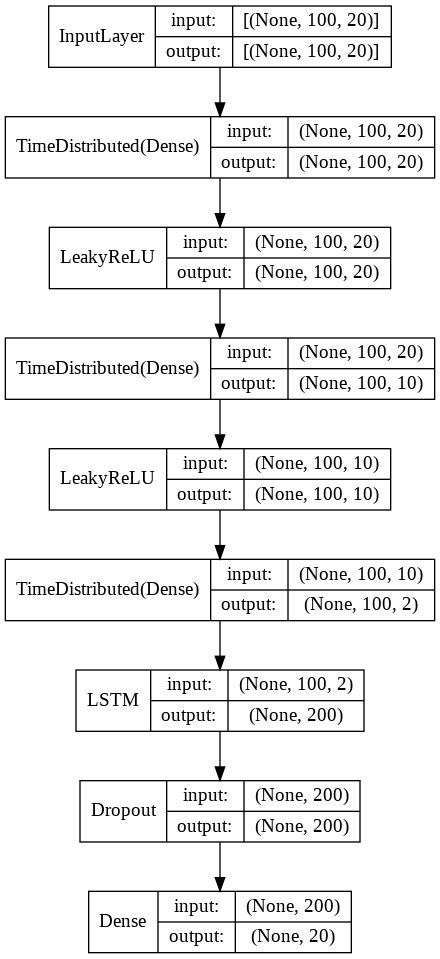

In [ ]:
plot_model(model,show_shapes = True,show_layer_names = False)

## Training

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.20404, saving model to /content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/LSTM/1102_2_.01-0.20.hdf5
38/38 - 9s - loss: 0.1631 - val_loss: 0.2040 - 9s/epoch - 225ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.20404 to 0.20037, saving model to /content/gdrive/My Drive/YAMAKAWA_LAB/predicition/NN/handmotion/LSTM/1102_2_.02-0.20.hdf5
38/38 - 4s - loss: 0.1594 - val_loss: 0.2004 - 4s/epoch - 103ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.20037
38/38 - 4s - loss: 0.1611 - val_loss: 0.2060 - 4s/epoch - 100ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.20037
38/38 - 4s - loss: 0.1603 - val_loss: 0.2058 - 4s/epoch - 100ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.20037
38/38 - 4s - loss: 0.1601 - val_loss: 0.2060 - 4s/epoch - 100ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.20037
38/38 - 4s - loss: 0.1600 - val_loss: 0.2067 - 4s/epoch - 104ms/step
Epoch 7/50

Ep

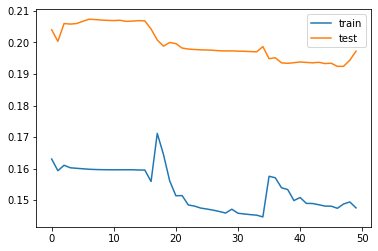

In [ ]:
# fit network
history = model.fit(train, train_label, epochs=50, batch_size=128, validation_split=0.1, verbose=2, shuffle=False,callbacks = [Modelcheckpoint])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               168800    
                                                                 
 dense (Dense)               (None, 10)                2010      
                                                                 
Total params: 170,810
Trainable params: 170,810
Non-trainable params: 0
_________________________________________________________________


In [ ]:

def getNewestModel(model, dirname):
    from glob import glob
    import os
    
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model

model = getNewestModel(model, save_dir)

In [ ]:

print(test_X.shape)
yhat = model.predict(test_X)
#print(yhat)
print(test_X.shape)
print(test_X.shape)
print(test_y.shape)

(587, 20, 10)
(587, 20, 10)
(587, 20, 10)
(587, 10)


##Evaluation

In [ ]:
#from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
def mean_squared_error(data1,data2):
  s=0
  for i in range(len(data1)):
    s+=(data1[i][0]-data2[i][0])**2+(data1[i][1]-data2[i][1])**2
  s=s/len(data1)
  return s**(1/2)

#trainScore = mean_squared_error(trainPredict,trainY)
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = mean_squared_error(testPredict,testY)
#print('Test Score: %.2f RMSE' % (testScore))

# make a prediction
yhat = model.predict(test_X)
yhat_train=model.predict(train1_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X_eva[:, :]), axis=1)z
inv_yhat = scaler.inverse_transform(yhat)
#inv_yhat = inv_yhat[:,:]
inv_yhat_train = scaler.inverse_transform(yhat_train)
#inv_yhat = inv_yhat[:,:]
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X_eva[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y_train = scaler.inverse_transform(train1_y)
inv_y = inv_y[:,:]

# calculate RMSE
print(inv_yhat)
rmse_test = mean_squared_error(inv_y, inv_yhat)
rmse_train = mean_squared_error(inv_y_train, inv_yhat_train)
print('Test RMSE: %.3f' % rmse_test)
print('Train RMSE: %.3f' % rmse_train)

110/110 [==============================] - 0s 4ms/step
[[382.87686  183.47914  386.01465  ...  10.915721 -48.66617   14.36874 ]
 [382.50064  184.65811  383.81924  ...  10.838896 -54.00991   13.907539]
 [383.4872   187.05904  384.5032   ...  10.471056 -57.13438   13.591415]
 ...
 [392.79172  216.53993  385.54245  ...  18.799408 -50.597702  14.513552]
 [391.55222  219.58083  385.69595  ...  19.749758 -48.49099   13.52999 ]
 [389.99057  221.04779  385.73364  ...  20.295439 -48.08448   12.680485]]
Test RMSE: 42.166
Train RMSE: 1.998


##Plot test data

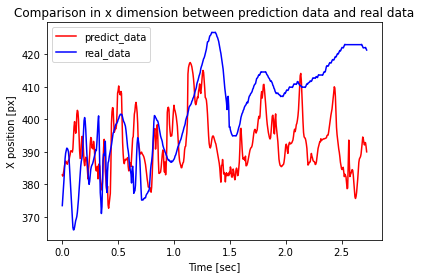

In [ ]:
#fps
fps=200
xhat=inv_yhat[:,0]
yhat=inv_yhat[:,1]
num_hat=[]
for i in range(len(xhat)):
  num_hat.append(i/fps)


x=inv_y[:,0]
y=inv_y[:,1]
num=[]
for i in range(len(xhat)):
  num.append(i/fps)
#グラフのプロット
plt.plot(num_hat ,xhat, color="r", label="predict_data")
plt.plot(num, x, color="b", label="real_data")
plt.ylabel("X position [px]")
plt.xlabel("Time [sec]")
plt.title("Comparison in x dimension between prediction data and real data")
plt.legend()
plt.show()

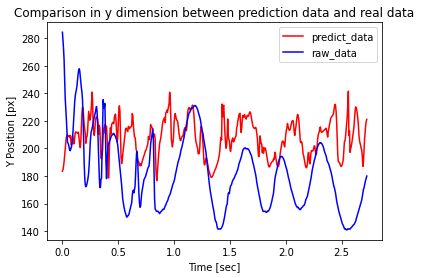

In [ ]:
plt.plot(num_hat ,yhat, color="r", label="predict_data")
plt.plot(num, y, color="b", label="raw_data")
plt.ylabel("Y Position [px]")
plt.xlabel("Time [sec]")
plt.title("Comparison in y dimension between prediction data and real data")
plt.legend()
plt.show()

##Predicciton

###long-term prediction 

In [ ]:
fps=200
look_back = 30
lookahead = 20
init_dat= predict_X[0,:] #predict_X shape:(350,)
scaled_eva = predict_X
# 未来の予測データを保存していく変数
print(init_dat.shape)

future_result = smooth_predict[:look_back+lookahead,:]
print("before adding predicted data shape:",future_result.shape)

predict = model.predict(predict_X)
print("predicted data shape:",predict.shape)

inv_ypred = scaler.inverse_transform(predict)
inv_yeva =smooth_predict

inv_ypred = np.append(future_result,inv_ypred,axis = 0)
print("after adding predicted data shape : ",inv_ypred.shape)

(30, 20)
before adding predicted data shape: (50, 20)
11/11 [==============================] - 0s 4ms/step
predicted data shape: (339, 20)
after adding predicted data shape :  (389, 20)


####step-by-step prediction

In [ ]:
#dataset for fututre prediction
#dataset_pred =pd.read_csv(filepath_or_buffer="/content/gdrive/My Drive/YAMAKAWA_LAB/30fps/2_vel_files.csv",header=0)
values_pred_eva = smooth_predict
values_pred = smooth_predict[0:look_back,:]

#print(values_pred)
# ensure all data is float
values_pred = values_pred.astype('float32')
values_pred_eva = values_pred_eva.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_pred = scaler.fit_transform(values_pred)
scaled_eva = scaler.fit_transform(values_pred_eva)
# frame as supervised learning
reframed_pred = series_to_supervised(scaled_pred, look_back, 1)

# drop columns we don't want to predict
#reframed_train.drop(reframed_train.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
#s=np.append(scaled_pred,[336,366])
#print(s.shape)
print(scaled_pred.shape)

(30, 20)


In [ ]:
look_back = 30
lookahead = 20 # 100 msec
dim = 20
init_dat=scaled_pred
# 未来の予測データを保存していく変数

print(init_dat.shape)
future_result = scaled_eva[:look_back+lookahead,:]

fps=200
# 未来の予測データを保存していく変数

print(init_data.shape)
future_result = predict[0,:-dim].reshape(look_back,dim)
future_result = future_result.tolist()
evaluation_data = predict[:,:-dim]
init_data = np.reshape(init_data, (1,look_back, dim))

# 未来予想
for step2 in range(int(fps)):

    test_data = np.reshape(init_dat, (1,look_back,dim))
    batch_predict = model.predict(test_data)
    init_dat=np.delete(init_dat,0,axis=0)
    init_dat = np.append(init_dat,batch_predict, axis=0)
    #print(batch_predict)
    future_result = np.append(future_result, batch_predict,axis=0)
    print(future_result)

inv_ypred = scaler.inverse_transform(future_result)
inv_yeva =scaler.inverse_transform(scaled_predict)



## Plot prediction data

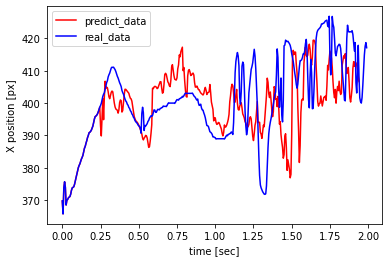

In [ ]:
fps=200
x_pred=inv_ypred[:,0]
y_pred=inv_ypred[:,1]
num_pred=[]
for i in range(len(x_pred)):
  num_pred.append(i/fps)


x_eva=inv_yeva[:,0]
y_eva=inv_yeva[:,1]
num_eva=[]

for i in range(len(x_eva)):
  num_eva.append(i/fps)


# sin波をプロット
plt.figure()
plt.plot(num_pred,x_pred, color="r", label="predict_data")
plt.plot(num_eva,x_eva, color="b", label="real_data")
plt.xlabel("time [sec]")
plt.ylabel("X position [px]")
#plt.title("X prediction(5 frames/hidden layer:100)")
#plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()

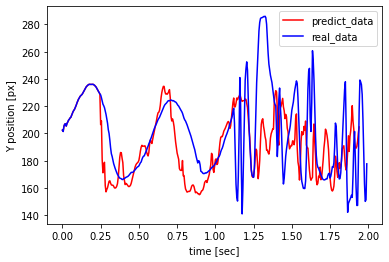

In [ ]:
plt.figure()
plt.plot(num_pred,y_pred, color="r", label="predict_data")
plt.plot(num_eva,y_eva, color="b", label="real_data")
plt.xlabel("time [sec]")
plt.ylabel("Y position [px]")
#plt.title("180 frames/hidden layer100")
#plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()

##Evaluation Prediction data

0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


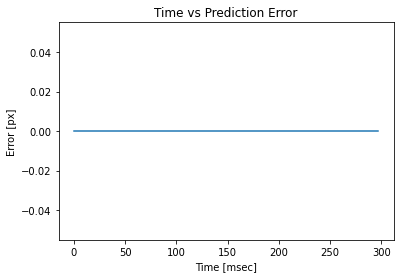

In [ ]:
error=[]
time=[]
def RMSE(dat1,dat2):
  sum=0
  for i in range(len(dat1)):
    sum+=(dat1[i]-dat2[i])**2
  sum=(sum/len(dat1))**(1/2)
  return sum

for i in range(0,10):
  time.append(i*33)
  rmse=RMSE(inv_ypred[i+look_back-1],inv_yeva[i+look_back-1]) #10msおき
  error.append(rmse)
print(error[0])
print(error)
plt.plot(time,error)
plt.title("Time vs Prediction Error")
plt.xlabel("Time [msec]")
plt.ylabel("Error [px]")
plt.show()

#Hyperparameter tuning

In [ ]:
## Hyperparameter tuning -> Keras Tuner training https://keras.io/guides/keras_tuner/getting_started/
!pip install -U keras-tuner

In [ ]:
from kerastuner.tuners import RandomSearch
import keras
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
#hyperparameter tuning:

## Hyperparameter tuning -> Keras Tuner training https://keras.io/guides/keras_tuner/getting_started/
!pip install -U keras-tuner
from kerastuner.tuners import RandomSearch
import keras
import tensorflow as tf
def build_model(hp):
  model = keras.Sequential()

    #for i in range(hp.Int("Conv Layers", min_value=0, max_value=3)): #Conv. layer: 0~3
  for i in range(hp.Int("Dense Layers", min_value=1, max_value=5)):
    model.add(keras.layers.LSTM(hp.Choice("Dense layer", [300]),activation="relu",return_sequences = True))

 # model.add(LSTM(200, return_sequences = True, 
 #             input_shape=(train1_X.shape[1], train1_X.shape[2]))) #(LSTM(hiddenLayer,inputshape(input_frame,dimension(the number of features)))))
 # for i in range(hp.Int("LSTMLayers", min_value = 0, max_value =1)):
  #model.add(LSTM(hp.Choice(1000,input_shape=(train1_X.shape[1], train1_X.shape[2]),return_sequences = True))#, return_sequences = True))_ #(LSTM(hiddenLayer,inputshape(input_frame,dimension(the number of features))))
  #model.add(LSTM(hp.Choice(f"{i} LSTM layer", [100,200,300]),return_sequences = True))#, return_sequences = True))_
  #model.add(LSTM(hp.Choice(f"{i} LSTM layer", [100,200,300,500]),return_sequences = True))#, return_sequences = True))_
  #model.add(LSTM(hp.Choice(f"{i} LSTM layer", [20,50,100])))#, return_sequences = True))_
  model.add(LSTM(10, return_sequences = False))
  model.add(keras.layers.Dense(10, activation = "softmax"))

  opt = keras.optimizers.Adam(learning_rate=0.001,decay=0.0001)
  model.compile(optimizer = opt,
                loss =tf.keras.losses.MeanSquaredError(),
                metrics =["mean_squared_error"])
  
  return model

import os

save_dir = "/content/gdrive/My Drive/YAMAKAWA_LAB/prediction/NN/fingermotion/1111_0/LSTM"
#src_img_dirがなかったら、srcフォルダを作成する
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

tuner = RandomSearch(
    build_model,
    objective = "mean_squared_error",
    max_trials = 100,
    directory = save_dir,
    project_name = "1111" #change every time
)

tuner.search(train, train_label,validation_split = 0.2, epochs=300, batch_size =16)

In [ ]:
model = tuner.get_best_models()[0]

best_model.summary()
#configure the result of the tuning
tuner.results_summary()

In [ ]:
import os
##Save and load the model 
best_model.save('/content/gdrive/My Drive/YAMAKAWA_LAB/prediction/NN/handmotion')

#src_img_dirがなかったら、srcフォルダを作成する
if not os.path.exists(src_img_dir):
  os.makedirs(src_img_dir)


In [ ]:
#load training model:
loaded_model = keras.models.load_model('/content/gdrive/My Drive/YAMAKAWA_LAB/技術補佐員/NN/model')